# Qdrant & Text Data

![qdrant](../images/crab_nlp.png)

Welcome to a tutorial on Natural Language Processing and Vector Databases! Here, we will explore how these two exciting technologies work together via Qdrant, a vector similarity search engine that provides a production-ready service with a convenient API to store, search, and manage vectors with an additional payload.

## Table of Contents

1. Learning Outcomes
2. Overview
3. Before We Get Started
4. NLP
    - The Task & The Data
    - Exploration
    - GPT-2 Embeddings
5. Semantic Search with Qdrant
6. Recommendations API
7. Conclusion
8. Resources

## 1. Learning Outcomes

By the end of this tutorial, you will be able to
- Generate embeddings from text data.
- Create collections of vectors using Qdrant.
- Conduct semantic search over a corpus of documents using Qdrant.
- Provide recommendations with Qdrant.

## 2. Overview

Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on the interaction between computers and human language. It involves teaching computers to understand, interpret, and generate human language in a way that is both meaningful and useful. NLP techniques can help us with tasks such as text classification, named entity recognition, sentiment analysis, and language generation.

Vector Databases, on the other hand, are a type of database that specializes in storing and querying high-dimensional vectors. In the context of NLP, vectors are numerical representations of words, sentences, or documents that capture their semantic meaning. These vector representations, often referred to as word embeddings or document embeddings, transform textual data into a numerical format that machines can easily process and analyze.

Vector Databases serve as efficient storage systems for these vector representations, allowing for fast and accurate similarity search. They enable users to find similar words, sentences, or documents based on their semantic meaning rather than relying solely on exact matches or keywords. By organizing vectors in a way that facilitates quick retrieval and comparison, Vector Databases are instrumental in powering various NLP applications, including information retrieval, recommendation systems, semantic search, and content clustering.

The connecting dot between NLP and Vector Databases lies in the importance of vector representations in NLP tasks. Vector representations enable NLP algorithms to understand the contextual relationships and semantic meaning of textual data. By leveraging Vector Databases, NLP systems can efficiently store and retrieve these vector representations, making it easier to process and analyze large volumes of textual data.

Throughout this tutorial, we will delve deeper into the fundamentals of NLP and Vector Databases. In particular, we will learn (at a high-level) how to use transformers to create embeddings for a corpus of news, and how to use Qdrant to search and recommend the best matches to a chosen document.

## 3. Before We Started

In order to use Qdrant, you will need to pull the latest image from docker hub with the command `docker pull qdrant/qdrant`. Next, you can initialize Qdrant with the following command.

```sh
docker run -p 6333:6333 \
    -v $(pwd)/qdrant_storage:/qdrant/storage \
    qdrant/qdrant
```

Now that you have Qdrant up and running, your next step is to set up a virtual environment with the packages we'll be using. You can do so via the following commands.

```sh
# with mamba or conda
mamba env create -n my_env python=3.10
mamba activate my_env

# or with virtualenv
python -m venv venv
source venv/bin/activate

# install packages
pip install qdrant-client transformers datasets torch sentence-transformers
```

After your have your environment ready, let's get started with Qdrant.

## 4. NLP & Vector Databases

The most common use case you will find at the time of writing, will likely involve large language models. You might have heard of models like [GPT-4](https://openai.com/product/gpt-4), [Codex](https://openai.com/blog/openai-codex), and [PaLM-2](https://ai.google/discover/palm2) which are powering incredible tools such as [ChatGPT](https://openai.com/blog/chatgpt), [GitHub Copilot](https://github.com/features/copilot), and [Bard](https://bard.google.com/?hl=en), respectively. These three models are part of a family of deep learning architectures called [transformers](https://arxiv.org/abs/1706.03762), which are known for their ability to learn long-range dependencies between words in a sentence. This ability to learn from text makes them well-suited for tasks such as machine translation, text summarization, and question answering.

Transformer models work by using a technique called attention, which allows them to focus on different parts of a sentence when making predictions. For example, if you are trying to translate a sentence from English to Spanish, the transformer model will use attention to focus on the words in the English sentence that are most important for the translation into Spanish.

One analogy that can be used to explain transformer models is to think of them as a group of people who are trying to solve a puzzle. Each person in the group is given a different piece of the puzzle, and they need to work together to figure out how the pieces fit together. The transformer model is like the group of people, and the attention mechanism is like the way that the people in the group communicate with each other.

In a more concise way, transformer models are a type of machine learning model that can learn long-range dependencies between words in a sentence by using (or paying 😉) attention.

In NLP, vector databases are used to store word embeddings. Word embeddings are vector representations of words that capture their semantic meaning, and these are used to improve the performance of different NLP tasks.

The transformers architecture has been incredibly influential in the field of machine learning, and one of the tools at the heart of this is the [`transformers`](https://huggingface.co/docs/transformers/index) library developed by the Hugging Face team. With it, getting embeddings from a corpus of text can be done in a very straightforward way.

Before we get started with the model, let's talk about the use case we will be covering here.

### 4.1 The Task & The Data

> We have been given the **task of creating a system that will recommend the most similar articles to any one article chosen by a user.** 

The dataset we will use is called the **AG News** dataset and here is a description from its [dataset card in Hugging Face](https://huggingface.co/datasets/ag_news):

> "AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html"

With that out of the way, let's download our dataset and load into our session.

In [87]:
from datasets import load_dataset

In [88]:
dataset = load_dataset("ag_news", split="train")
dataset

Found cached dataset ag_news (/home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

If you have never used HuggingFace's [`datasets`](https://huggingface.co/docs/datasets/index) library you might be a little puzzled regarding what just happened. Let's break it apart.

- The `datasets` library is a tool that allows us to manipulate unstructured data in a very efficient way by using [Apache Arrow](https://arrow.apache.org/) under the hood. It has a lot of useful functionalities for massaging and shaping up the data in whatever way we need it to be for our task. (It is safe to call it the pandas of unstructured data.)
- Next, we imported the `load_dataset` function and used it to download the dataset from the [HuggingFace Data Hub](https://huggingface.co/datasets) directly into our PC's.
- Lastly, by indicating that we want to "split" our dataset into a `train` set only, we are effectively indicating that we do not want any partitions.

Let's have a look at a couple of samples.

### 4.2 Exploration

In [89]:
from random import choice

for i in range(5):
    random_sample = choice(range(len(dataset)))
    print(f"Sample {i+1}")
    print("=" * 70)
    print(dataset[random_sample]['text'])
    print()

Sample 1
Microsoft issues SP2 patch com September 22, 2004, 12:09 PM PT. OS Migration has moved to the bottom ranks after making its mark on IT Professional #39;s top five priority last year.

Sample 2
Stocks Post Early Gains As Oil Is Steady Stocks are posting some early gains this morning. The Dow Jones Industrial Average is up 10 points in today #39;s early going. Advancing issues on the New York Stock Exchange hold a 4-3 lead over decliners.

Sample 3
U.S. Report Turns Focus to Greenhouse Gases Previously, the Bush administration stressed uncertainties in understanding the causes and consequences of global warming.

Sample 4
U.S., Afghan Soldiers Arrest 10 Suspects (AP) AP - U.S. and Afghan soldiers conducting a sweep in southern Zabul province arrested 10 suspected Taliban after a firefight in a forbidding mountain area, the governor said Saturday.

Sample 5
Intel expands Centrino family Based on Intel #39;s mobile architecture, the new Intel Pentium M processor 765 processor feat

One nice feature of HuggingFace datasets' objects is that we can switch effortlessly to a pandas dataframe by using the method `.pandas()`, and this can come in handy when we want to manipulate and plot our data. Let's let's extract the class names of news articles and plot the frequency with which they appear. 

In [90]:
id2label = {str(i): label for i, label in enumerate(dataset.features["label"].names)}

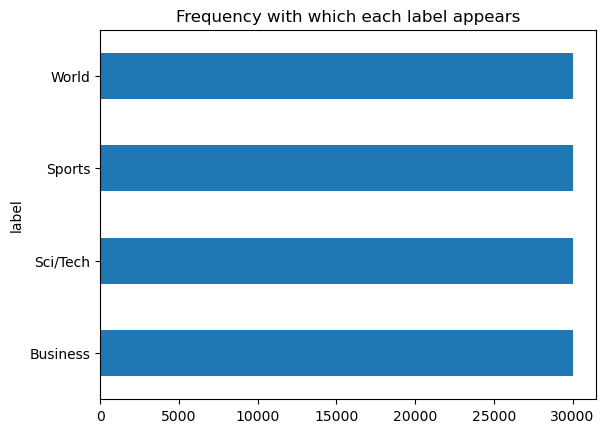

In [91]:
(
    dataset.select_columns('label')
           .to_pandas()
           .astype(str)['label']
           .map(id2label)
           .value_counts()
           .plot(kind="barh", title="Frequency with which each label appears")
);

As you can see, we have a very well-balanced dataset at our disposal. Let's look at the average length of news per class label. We will write a function for this and map to all of the elements in our dataset. Note that `'length_of_text'` will be the new column in our dataset.

In [92]:
def get_lenght_of_text(example):
    example['length_of_text'] = len(example['text'])
    return example

dataset = dataset.map(get_lenght_of_text)
dataset[:10]['length_of_text']

Loading cached processed dataset at /home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-e971d9966c1fdaf5.arrow


[144, 266, 232, 256, 234, 239, 215, 252, 414, 147]

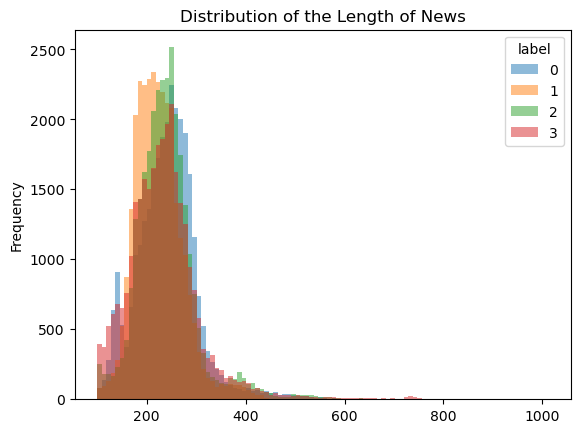

In [93]:
(
    dataset.select_columns(["label", "length_of_text"])
           .to_pandas()
           .pivot(columns='label', values='length_of_text')
           .plot.hist(bins=100, alpha=0.5, title="Distribution of the Length of News")
);

The length of characters in the news articles seem to be quite similar for all the labels, and that's okay as very large documents might need to be broken apart before we get to feed them to our model. 

### 4.3 GPT-2 Embeddings



Our next step will be to use a pre-trained model to tokenize our data and create an embedding layer based on it.

Tokenization is like breaking down a sentence into smaller pieces called "tokens." These tokens can be words, numbers, curly brackets, or even punctuation marks. This process helps computers understand and analyze text more easily because they can treat each token as a separate unit and work with them individually.

The model we will use to tokenize our news articles and extract the embeddings is [GPT-2](https://huggingface.co/gpt2). GPT-2 is a powerful language model created by OpenAI, and it is like a smart computer program that has been trained on a lot of text from the internet. You can think of it as an AI that can generate human-like text and answer questions based on what it has learned. GPT-2 can be used for a variety of things, like writing articles, creating chatbots, generating story ideas, or even helping with language translation.

In order to tokenize our corpus, we will use two classes from the `transformers` library, AutoTokenizer and AutoModel, and these will make use of the version of GPT-2 we give them. The example below takes inspiration from an example available on Chapter 9 of the excellent book, [Natural Language Processing with Transformers](https://transformersbook.com/) by Lewis Tunstall, Leandro von Werra, and Thomas Wolf.

If you would like to use a different model to follow along, you can find all of the models available at [Hugging Face's model hub](https://huggingface.co/models)

In [94]:
from transformers import AutoModel, AutoTokenizer
import torch

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModel.from_pretrained('gpt2')#.to(device) # switch this for GPU

Before we walk through an example of tokenization and embedding extraction, we will need to set a padding token for GPT-2. In natural language processing (NLP), padding refers to adding extra tokens to make all input sequences the same length. When processing text data, it's common for sentences or documents to have different lengths. However, many machine learning models require fixed-size inputs. Padding solves this issue by adding special tokens (such as zeros) to the shorter sequences, making them equal in length to the longest sequence in the dataset. For example, say you have a set of sentences and you want to process them using a model that requires fixed-length input, you may pad the sequences to match the length of the longest sentence, let's say five tokens. The padded sentences would look like this:

1. "I love cats" -> "I love cats [PAD] [PAD]"
2. "Dogs are friendly" -> "Dogs are friendly [PAD]"
3. "Birds can fly" -> "Birds can fly [PAD] [PAD]"

By padding the sequences, you ensure that all inputs have the same size, allowing the model to process them uniformly. Because GPT-2 does not have a padding token, we will use the "end of text" token instead.

In [96]:
tokenizer.eos_token

'<|endoftext|>'

In [97]:
tokenizer.pad_token

Using pad_token, but it is not set yet.


In [98]:
tokenizer.pad_token = tokenizer.eos_token

 With that out of the way, let's walk through a quick example.

In [99]:
text = "What does a cow use to do math? A cow-culator."
inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")#.to(device)
inputs

{'input_ids': tensor([[ 2061,   857,   257,  9875,   779,   284,   466, 10688,    30,   317,
          9875,    12,  3129,  1352,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Our tokenizer will returns an input IDs and an attention mask for every word in our sentence. These IDs are represented internally in the vocabulary of the model. To view our tokens we can use the following method.

In [100]:
toks = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
toks

['What',
 'Ġdoes',
 'Ġa',
 'Ġcow',
 'Ġuse',
 'Ġto',
 'Ġdo',
 'Ġmath',
 '?',
 'ĠA',
 'Ġcow',
 '-',
 'cul',
 'ator',
 '.']

We can always go back to a sentence as well.

In [101]:
tokenizer.convert_tokens_to_string(toks)

'What does a cow use to do math? A cow-culator.'

And if you are curious about how large is the vocabulary in your model, you can always access it with the method `.vocab_size`.

In [102]:
tokenizer.vocab_size

50257

Now it is time to pass the inputs we got from our tokenizer to our model and examine what we'll get in return.

In [103]:
with torch.no_grad():
    embs = model(**inputs)

embs.last_hidden_state.size(), embs[0]

(torch.Size([1, 15, 768]),
 tensor([[[-0.1643,  0.0957, -0.2844,  ..., -0.1632, -0.0774, -0.2154],
          [ 0.0472,  0.2181,  0.0754,  ...,  0.0281,  0.2386, -0.0731],
          [-0.1410,  0.1957,  0.5674,  ..., -0.4050,  0.1199, -0.0043],
          ...,
          [ 0.0686,  0.2000,  0.2881,  ...,  0.2151, -0.5111, -0.2907],
          [-0.0662,  0.3934, -0.8001,  ...,  0.2597, -0.1465, -0.1695],
          [-0.1900, -0.2704, -0.3135,  ...,  0.3318, -0.4120, -0.0153]]]))

Notice that we got a tensor of shape `[batch_size, inputs, dimensions]`. The inputs are our tokens and these dimensions are the embedding representation that we want for our sentence rather than each token. So what can we do to get one rather than 15? The answer is **mean pooling**. We are going to take the average of all 15 vectors while paying attention to the most important parts of it. The details of how this is happening are outside of the scope of this tutorial, but please refer to the Natural Language Processing with Transformers book mentioned earlier for a richer discussion on the concepts touched on in this section (including the borrowed functions we are about to use).

In [104]:
def mean_pooling(model_output, attention_mask):

    token_embeddings = model_output[0]
    input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [105]:
embedding = mean_pooling(embs, inputs["attention_mask"])
embedding.shape, embedding[0, :10]

(torch.Size([1, 768]),
 tensor([-0.2175, -0.0280, -0.4393, -0.0739, -0.1338,  0.3550,  3.4335,  0.1762,
         -0.1412,  0.1184]))

Now we have everything we need to extract the embedding layers from our corpus of news. The last piece of the puzzle is to create a function that we can map to every news article and extract the embedding layers with. Let's do that using our tokenizer and model from earlier, and, since our dataset contains quite a bit of articles, we'll apply it to a smaller subset of the data.

In [106]:
def embed_text(examples):
    inputs = tokenizer(
        examples["text"], padding=True, truncation=True, return_tensors="pt"
    )#.to(device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [107]:
small_set = (
    dataset.shuffle(42) # randomly shuffles the data, 42 is the seed
           .select(range(1000)) # we'll take 1k rows
           .map(embed_text, batched=True, batch_size=128) # and apply our function above to 128 articles at a time
)

Loading cached shuffled indices for dataset at /home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-f5357753235abe0c.arrow
Loading cached processed dataset at /home/ramonperez/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-84bae01db6f22a9e.arrow


In [108]:
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding'],
    num_rows: 1000
})

As you can see, we now have an extra column with the embeddings for our data, and we can use these vector representations to semantically search for other news articles or to recommend similar articles to our users by taking advantage of Qdrant.

Before we add our news articles to Qdrant, let's create a list of ids for our dataset and a column with the labels to allow our users to get recommendations in a more precise fashion, i.e. by context.

In [109]:
n_rows = range(len(small_set))
small_set = small_set.add_column("idx", n_rows)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx'],
    num_rows: 1000
})

In [110]:
small_set['idx'][-10:]

[990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

In [111]:
def get_names(label_num):
    return id2label[str(label_num)]

label_names = list(map(get_names, small_set['label']))
small_set = small_set.add_column("label_names", label_names)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx', 'label_names'],
    num_rows: 1000
})

We will also need the amount of dimensions of our embeddings.

In [112]:
dim_size = len(small_set[0]["embedding"]) # we'll need the dimensions of our embeddings
dim_size

768

## 5. Semantic Search with Qdrant

The two modules we'll use the most are the `QdrantClient` and the `models` one. The former allows us to connect to our container running Qdrant, and the latter will give us the rest of the utilities we'll need to manage our collections. 

As a quick reminder, [collections](https://qdrant.tech/documentation/collections/) are named sets of points among which you can search; [points](https://qdrant.tech/documentation/points/) consist of a vector, an optional id and an optional payload; an id a unique identifier for your vectors, and a [payload](https://qdrant.tech/documentation/payload/) is a JSON object with additional data you can add to your points. Each collection needs a distance metric such as Euclidean Distance, Dot Product, or Cosine Similarity.

We'll start by instantiating our client using `host="localhost"` and `port=6333` (as it is the default we used earlier with docker), and by creating a new collection called, `news_embeddings`.

In [113]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import CollectionStatus

In [114]:
client = QdrantClient(host="localhost", port=6333)
client

In [115]:
my_collection = "news_embeddings"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=dim_size, distance=models.Distance.COSINE)
)

True

Before we fill in our new collection, we want to create a payload that contains the news domain the article belongs to, plus the article itself. Note that this payload is a list of JSON objects where the key is the name of the column and the value is the label or text of that same column.

Something that could be incredibly useful is to refocus our model to apply named entity recognition to our articles and extract characteristics from the text that could be use to further filter the user's search via the payload. This will be for another tutorial though.

In [116]:
payloads = small_set.select_columns(["label_names", "text"]).to_pandas().to_dict(orient="records")
payloads[:3]

[{'label_names': 'World',
  'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'},
 {'label_names': 'Sports',
  'text': 'Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.'},
 {'label_names': 'World',
  'text': 'Will Putin #39;s Power Play Make Russia Safer? Outwardly, Russia has not changed since the barrage of terrorist attacks that culminated in the school massacre in Beslan on Sept.'}]

In [117]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=small_set["idx"],
        vectors=small_set["embedding"],
        payloads=payloads
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

We can verify that our collection has been created by scrolling through the points with the following command.

In [118]:
client.scroll(
    collection_name=my_collection, 
    limit=10,
    with_payload=False, # change to True to see the payload
    with_vectors=False  # change to True to see the vectors
)

([Record(id=0, payload=None, vector=None),
  Record(id=1, payload=None, vector=None),
  Record(id=2, payload=None, vector=None),
  Record(id=3, payload=None, vector=None),
  Record(id=4, payload=None, vector=None),
  Record(id=5, payload=None, vector=None),
  Record(id=6, payload=None, vector=None),
  Record(id=7, payload=None, vector=None),
  Record(id=8, payload=None, vector=None),
  Record(id=9, payload=None, vector=None)],
 10)

Now that we have our collection ready, let's start querying the data and see what we get.

In [119]:
query1 = small_set[100]['embedding']
small_set[100]['text'], query1[:7]

('Stocks creep higher in New York NEW YORKUS blue-chip stocks ended barely higher yesterday as a spike in oil prices to record closing levels pared earlier gains and renewed concerns about the effect of high energy prices on consumer spending and corporate profits.',
 [0.12031637877225876,
  0.046753425151109695,
  0.11301225423812866,
  0.4455118477344513,
  0.05810461565852165,
  -0.09899616241455078,
  1.7481721639633179])

As you can see the text above is talking about stocks so let's have a look at what kinds of articles we can find with Qdrant.

In [120]:
client.search(
    collection_name=my_collection,
    query_vector=query1,
    limit=3
)

[ScoredPoint(id=100, version=0, score=0.99999994, payload={'label_names': 'Business', 'text': 'Stocks creep higher in New York NEW YORKUS blue-chip stocks ended barely higher yesterday as a spike in oil prices to record closing levels pared earlier gains and renewed concerns about the effect of high energy prices on consumer spending and corporate profits.'}, vector=None),
 ScoredPoint(id=789, version=0, score=0.9995748, payload={'label_names': 'World', 'text': 'German investor confidence surges BERLIN - German investor confidence posted a surprise jump in December as relief over falling oil prices helped to offset concerns about the impact of a surging euro on growth in Europe #39;s biggest economy.'}, vector=None),
 ScoredPoint(id=379, version=0, score=0.9994168, payload={'label_names': 'Business', 'text': 'German recovery already running out of steam: research institutes (AFP) AFP - The German economy, which grew strongly in the first half of this year on the back of robust exports,

Of course, the first article is going to be the same one we used to query the data as there is no distance between the same vector. The other interesting thing we can see here is that even though we have different labels, we still get semantically similar articles with the label `World` as we do with the label `Business`.

The nice thing about what we have done is that we are getting decent results and we haven't even fine-tuned the model to our use case. To fine-tune a model means to take a pre-trained model that has learned general knowledge from (usually large amounts of) data and adapt it to a specific task or domain. It's like giving a smart assistant some additional training to make them better at a particular job. When we do this, we should expect even better results from our search.

Let's pick a random sample from the larger dataset and see what we get back from Qdrant. Note that because our function was created to be applied on a dictionary object, we'll represent the random text in the same way.

In [121]:
# Step 1 - Select Random Sample
query2 = {"text": dataset[choice(range(len(dataset)))]['text']}
query2

{'text': 'Gates stumps in Silicon Valley BERKELEY, Calif.--Microsoft Chairman Bill Gates kicked off a whirlwind day in the Bay Area on Friday, talking to college students about a range of topics, from open-source software to malaria to the next Xbox.'}

In [122]:
# Step 2 - Create a Vector
query2 = embed_text(query2)['embedding'][0, :]
query2.shape, query2[:20]

((768,),
 array([ 0.27911383, -0.14576922, -0.1527736 , -0.08721901, -0.18560958,
        -0.28628337,  2.8304303 ,  0.14360578, -0.04025106,  0.2308119 ,
        -0.2224071 , -0.13177449,  0.1385127 ,  0.02497307, -0.42708236,
         0.02807676, -0.19353206, -0.16147819,  0.22520797, -0.36993647],
       dtype=float32))

In [123]:
query2.tolist()[:20]

[0.2791138291358948,
 -0.14576922357082367,
 -0.15277360379695892,
 -0.08721901476383209,
 -0.1856095790863037,
 -0.28628337383270264,
 2.830430269241333,
 0.1436057835817337,
 -0.04025105759501457,
 0.23081189393997192,
 -0.22240710258483887,
 -0.13177448511123657,
 0.13851270079612732,
 0.0249730683863163,
 -0.427082359790802,
 0.028076764196157455,
 -0.1935320645570755,
 -0.161478191614151,
 0.22520796954631805,
 -0.369936466217041]

In [124]:
# Step 3 - Search for similar articles. Don't forget to convert the vector to a list.
client.search(
    collection_name=my_collection,
    query_vector=query2.tolist(),
    limit=5
)

[ScoredPoint(id=712, version=0, score=0.9995049, payload={'label_names': 'Sci/Tech', 'text': "Tech Whiz Aims to Boost Third World Care (AP) AP - Vikram Kumar is hardly your typical tech chief executive. He shares a two-bedroom apartment with a sister and a nephew and gets around town by bicycle or in a 20-year-old Mercedes Benz. The 28-year-old MIT graduate works days as a pathology resident at Brigham and Women's Hospital across the Charles River in Boston and only turns his energies at night to his business: improving rural health care in the developing world with handheld computer technology."}, vector=None),
 ScoredPoint(id=794, version=0, score=0.999445, payload={'label_names': 'Business', 'text': 'Gap wants to dress boomer women In the second half of 2005, Gap Inc. plans to launch its first new chain in a decade, a specialty clothing retailer aimed at women over 35 years old, according to a published report Wednesday citing Gap Chief Executive Paul Pressler.'}, vector=None),
 Sco

Because we selected a random sample, you will see something different everytime you go through this part of the tutorial so make sure you read some of the articles that come back and evaluate the similarity of these articles to the one you randomly got from the larger dataset. Have some fun with it. 🙂

Let's make things more interesting and pick the most similar results from a Business context. We'll do so by creating a field condition with `models.FieldCondition()` with the `key=` parameter set to `label_names` and the `match=` parameter set to `"Business"` via the `models.MatchValue()` function.

In [125]:
business = models.Filter(
    must=[models.FieldCondition(key="label_names", match=models.MatchValue(value="Business"))]
)

We will add our `business` variable as a query filter to our `client.search()` call and see what we get.

In [126]:
client.search(
    collection_name=my_collection,
    query_vector=query2.tolist(),
    query_filter=business,
    limit=5
)

[ScoredPoint(id=794, version=0, score=0.999445, payload={'label_names': 'Business', 'text': 'Gap wants to dress boomer women In the second half of 2005, Gap Inc. plans to launch its first new chain in a decade, a specialty clothing retailer aimed at women over 35 years old, according to a published report Wednesday citing Gap Chief Executive Paul Pressler.'}, vector=None),
 ScoredPoint(id=386, version=0, score=0.9994448, payload={'label_names': 'Business', 'text': 'Update 2: Immucor CEO to Step Aside During Probe Immucor Inc. said president and chief executive are under criminal investigation in Italy for alleged improper payments to a doctor, the maker of blood-testing equipment said Tuesday.'}, vector=None),
 ScoredPoint(id=718, version=0, score=0.9994038, payload={'label_names': 'Business', 'text': 'Rivals Join To Develop Hybrid-Car Technology General Motors Corp. and DaimlerChrysler AG are throwing their combined weight behind a new hybrid technology for cars and trucks, setting th

## 6. Recommendations API

You might notice that even though the similarity score we are getting seem quite high, the results seem to be a bit all over the place. To solve this, we could fine-tune our model and create a new embedding layer, but that would take some time and, most-likely, a GPU.

What we can do instead is to pick a model that works better off the bat and test the quality of the embeddings while we explore the recommendations API of Qdrant.

Let's do just that by using the package [`sentence_transformers`](https://www.sbert.net/index.html#) with the model `all-MiniLM-L6-v2`.

In [127]:
from sentence_transformers import SentenceTransformer, util

In [128]:
model = SentenceTransformer('all-MiniLM-L6-v2')

We will call the second embedding feature `embedding_2`.

In [129]:
def get_st_embedding(example):
    example['embedding_2'] = model.encode(example['text'])
    return example

small_set = small_set.map(get_st_embedding)

In [130]:
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx', 'label_names', 'embedding_2'],
    num_rows: 1000
})

Now that we have the new embedding layer, let's create a new collection with the same `small_set`, `ids`, and `payload`, and call this collection `better_news`.

In [131]:
second_collection = "better_news"
client.recreate_collection(
    collection_name=second_collection,
    vectors_config=models.VectorParams(
        size=len(small_set[0]['embedding_2']),
        distance=models.Distance.COSINE
    )
)

True

In [132]:
client.upsert(
    collection_name=second_collection,
    points=models.Batch(
        ids=small_set['idx'],
        vectors=small_set['embedding_2'],
        payloads=payloads
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

Let's pick a random news article.

In [133]:
some_txt = small_set[780]['text']
some_txt

'IBM adds four-way 550 server to new i5 product line IBM Corp. bolstered the new eServer i5 server lineup with the i5 550, a new system based on the Power 5 chip that can run multiple operating systems.'

It seems to be talking about IBM and its servers. Let's get the embedding layer for it.

In [134]:
query3 = model.encode(the_txt)
query3[:10]

array([-0.06654751, -0.03924084,  0.02900439, -0.04977767,  0.03995508,
       -0.02136424, -0.00713737, -0.01952819,  0.02204445,  0.00150797],
      dtype=float32)

They key thing about the recommendation API of Qdrant is that we need to give it at least 1 id for an article that user liked, or gave us a 👍 for.

In [135]:
article_we_liked = small_set[707]
article_we_liked['idx'], article_we_liked['text']

(707,
 'Google Desktop Last Thursday Google released a version of its online search for your computer. I wanted to test-drive it before reporting. Knowing the excruciating delays using Windows Search, I can say after only a weekend ')

The one above talks about about Google search. Let's see what kind of recommendations we get.

In [136]:
client.recommend(
    collection_name=second_collection,
    query_vector=query3.tolist(),
    positive=[article_we_liked['idx']],
    limit=5
)

[ScoredPoint(id=763, version=0, score=0.61914444, payload={'label_names': 'Sci/Tech', 'text': 'Yahoo Details Desktop Search Plans; Ask Jeeves  amp; MSN Launch This &lt;b&gt;...&lt;/b&gt; Yahoo has announced that it will release a desktop search product after the New Year, putting the search engine firmly in the desktop search race that Google kicked off earlier this year and that other major search engines have already declared that they '}, vector=None),
 ScoredPoint(id=554, version=0, score=0.5257321, payload={'label_names': 'Sci/Tech', 'text': 'Microsoft heats up search engine war The launch of Microsoft #39;s new search engine has ignited a new war for control of the Internet, according to analysts. A global beta, or test version of MSN Search, was launched on Thursday in 26 markets and '}, vector=None),
 ScoredPoint(id=312, version=0, score=0.46851987, payload={'label_names': 'Sci/Tech', 'text': ' #39;Mr. Bill Gates, you #39;re no Google #39; Microsoft Corp. isnt often an underdog

Not surprisingly, we get a lot of tech news with decent degrees of similarity.

Let's see what happens when we tell it that we want to see news related to Manchester United, that like news about workers' rights and that we dislike anything related to raising interests rates.

In [137]:
another_article_we_liked = small_set[412]
another_article_we_liked['idx'], another_article_we_liked['text']

(412,
 'Workers pushing for structure change at GM Europe, representative &lt;b&gt;...&lt;/b&gt; Employees at General Motors Corp. in Europe have discussed a major overhaul of the corporate structure in negotiations with management, the chief employee representative said in an interview published Sunday.')

In [138]:
article_we_dont_like = small_set[172]
article_we_dont_like['idx'], article_we_dont_like['text']

(172,
 'Interest Rates Expected To Rise The Federal Reserve is likely to announce a quarter-point rise in the federal funds target rate from 1.75 percent to 2.0 percent, economists and traders agree.')

In [139]:
some_other_txt = small_set[788]['text']
some_other_txt

'United May Offer Malcolm Glazer Seat on Board, Observer Says Manchester United Plc may offer US billionaire Malcolm Glazer a seat on its board if he agrees to drop a takeover bid for a year, the Observer said, citing an unidentified person in the soccer industry.'

In [140]:
query4 = model.encode(some_other_txt)

In [141]:
client.recommend(
    collection_name=second_collection,
    query_vector=query4.tolist(),
    positive=[article_we_liked['idx'], another_article_we_liked['idx']],
    negative=[article_we_dont_like['idx']],
    limit=8
)

[ScoredPoint(id=312, version=0, score=0.35078686, payload={'label_names': 'Sci/Tech', 'text': ' #39;Mr. Bill Gates, you #39;re no Google #39; Microsoft Corp. isnt often an underdog in anything, so when the software powerhouse released its new search engine, I was anxious to give it a whirl.'}, vector=None),
 ScoredPoint(id=763, version=0, score=0.3423614, payload={'label_names': 'Sci/Tech', 'text': 'Yahoo Details Desktop Search Plans; Ask Jeeves  amp; MSN Launch This &lt;b&gt;...&lt;/b&gt; Yahoo has announced that it will release a desktop search product after the New Year, putting the search engine firmly in the desktop search race that Google kicked off earlier this year and that other major search engines have already declared that they '}, vector=None),
 ScoredPoint(id=554, version=0, score=0.3300779, payload={'label_names': 'Sci/Tech', 'text': 'Microsoft heats up search engine war The launch of Microsoft #39;s new search engine has ignited a new war for control of the Internet, ac

The results seem palatable given our search criteria. Let's try one more without the article we liked about Google search, but this time, we want to set a similarity threshold to make sure get only very relevant results.

In [142]:
client.recommend(
    collection_name=second_collection,
    query_vector=query4.tolist(),
    positive=[another_article_we_liked['idx']],
    negative=[article_we_dont_like['idx']],
    score_threshold=0.30,
    limit=8
)

[ScoredPoint(id=491, version=0, score=0.36737645, payload={'label_names': 'Business', 'text': 'Jaguar workers say no to strike Workers at Jaguar #39;s Browns Lane plant have voted 55 to 45 against strike action over the company #39;s plans to move car production from the Coventry factory to Castle Bromwich in Birmingham as part of a restructuring programme which will mean the loss of '}, vector=None),
 ScoredPoint(id=748, version=0, score=0.35172254, payload={'label_names': 'Business', 'text': 'GM to lay off 950 in New Jersey SAN FRANCISCO (CBS.MW) -- General Motors said Tuesday that it will lay off 950 employees at its assembly plant in Linden, NJ, due to waning demand for the Chevy Blazer and GMC Jimmy.'}, vector=None),
 ScoredPoint(id=734, version=0, score=0.34378976, payload={'label_names': 'Business', 'text': 'GM Unit Opel to Cut 9,500 German Jobs  FRANKFURT (Reuters) - General Motors\' &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=GM.N target=/stocks/quickinfo

That's it! 🙌 

To see all of the collections that we have created today, you can use `client.get_collections`.

In [143]:
client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='better_news'), CollectionDescription(name='news_embeddings'), CollectionDescription(name='first_collection')])

You now have gone over a whirlwind tour of NLP and vector databases and are ready to tackle new challenges. 😎

## 5. Conclusion

In conclusion, we have explored a bit of the fascinating world of vector databases, natural language processing, transformers, and embeddings. In this tutorial we learned that (1) vector databases provide efficient storage and retrieval of high-dimensional vectors, making them ideal for similarity-based search tasks. (2) Natural language processing enables us to understand and process human language, opening up possibilities for different kinds of useful applications for digital technologies. (3) Transformers, with their attention mechanism, capture long-range dependencies in language and achieve incredible results in different tasks. Finally, embeddings encode words or sentences into dense vectors, capturing semantic relationships and enabling powerful language understanding.

By combining these technologies, we can unlock new levels of language understanding, information retrieval, and intelligent systems that continue to push the boundaries of what's possible in the realm of AI.

## 6. Resources

Here is a list with some resources that we found useful, and that helped with the development of this tutorial.

1. Books
    - [Natural Language Processing with Transformers](https://transformersbook.com/) by Lewis Tunstall, Leandro von Werra, and Thomas Wolf
    - [Natural Language Processing in Action, Second Edition](https://www.manning.com/books/natural-language-processing-in-action-second-edition) by Hobson Lane and Maria Dyshel
2. Articles
    - [Fine Tuning Similar Cars Search](https://qdrant.tech/articles/cars-recognition/)
    - [Q&A with Similarity Learning](https://qdrant.tech/articles/faq-question-answering/)
    - [Question Answering with LangChain and Qdrant without boilerplate](https://qdrant.tech/articles/langchain-integration/)
    - [Extending ChatGPT with a Qdrant-based knowledge base](https://qdrant.tech/articles/chatgpt-plugin/)
3. Videos
    - [Word Embedding and Word2Vec, Clearly Explained!!!](https://www.youtube.com/watch?v=viZrOnJclY0&ab_channel=StatQuestwithJoshStarmer) by StatQuest with Josh Starmer
    - [Word Embeddings, Bias in ML, Why You Don't Like Math, & Why AI Needs You](https://www.youtube.com/watch?v=25nC0n9ERq4&ab_channel=RachelThomas) by Rachel Thomas
4. Courses
    - [fast.ai Code-First Intro to Natural Language Processing](https://www.youtube.com/playlist?list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9)
    - [NLP Course by Hugging Face](https://huggingface.co/learn/nlp-course/chapter1/1)